# Roadmap

The goal of this notebook is to provide an example of how to scrape NEXRAD level II data and use pyart and csu_radar_tools to calculate and plot radar rainfall storm total and compute basin average time series

  1. Find available NEXRAD data
  2. Download NEXRAD data
  3. Mask bad data
  4. Download sounding data
  5. Classify hydrometeors
  6. Compute rainfall estimate
  7. Interpolate radially
  8. plot

Before getting started, set up your environment with all the necessities to run this notebook. To create this environment just run **`$ conda env create -f environment.yml`** where **`environment.yml`** is a file containing the following:

In [1]:
!cat environment.yml

name: radar
channels:
- conda-forge
- defaults
dependencies:
- python=2.7
- arm_pyart
- basemap
- basemap-data-hires
- matplotlib
- jupyter
- pandas
- numpy
- cython
- wget
- lxml
- pyproj
- pip:
  - skewt
  - git+git://github.com/CSU-Radarmet/CSU_RadarTools.git


## Run and load the rainfall processing functions

In [29]:
from pyart_radar_tools import *

def process_radar(path, sounding):
    radar = pyart.io.read(path)
    radar, start_gate, end_gate = mask_data(radar)
    dp_radar, vel_radar = separate_dp_vel_sweeps(radar)
    sw_vel_mask = construct_sw_vel_mask(vel_radar)
    radar = mask_dp_fiels(vel_radar, dp_radar, sw_vel_mask)
    radar = calculate_hidro_rain(radar, sounding)
    radar = calculate_rain_nexrad(radar)
    radar = calculate_rain_kdp(radar)
    for field in ['rain', 'r_kdp', 'r_z']:   
        radar = interpolate_radially(radar, field, start_gate, end_gate, interpolate_max=10)
    return radar


In [30]:
import numpy as np
import pandas as pd
from skewt import SkewT
import xarray as xr


## Define radar and times

In [31]:
ID='KICX'
latitude = 37.59
longitude = -112.86

year=2015

month=9
day=14
hour=18

t_start = '2015-09-14 18:00:00'
t_end = '2015-09-15 00:00:00'

## Find Available Data

First we will see what data are available for the date and site that we are interested in. 

In [32]:
Y = '{Y:04d}'.format(Y=year)
M = '{M:02d}'.format(M=month)
D = '{D:02d}'.format(D=day)

url = 'http://www.ncdc.noaa.gov/nexradinv/bdp-download.jsp?id={ID}&yyyy={Y}&mm={M}&dd={D}&product=AAL2'.format(
       ID=ID, Y=Y, M=M, D=D)
print url

http://www.ncdc.noaa.gov/nexradinv/bdp-download.jsp?id=KICX&yyyy=2015&mm=09&dd=14&product=AAL2


## Create time stamp and filenames for each file in the day

In [33]:
%%time
from lxml.html import parse
import fnmatch

page = parse(url)
data_urls = [el.find("a").get("href") for el in page.xpath("//div[@class='bdpLink']")]
data_urls = fnmatch.filter(data_urls, '*.gz')
filenames = [data_url.split('/')[-1] for data_url in data_urls]
times = pd.DatetimeIndex([pd.Timestamp(fn[4:19].replace('_', ' ')) for fn in filenames])

CPU times: user 6.37 ms, sys: 1.01 ms, total: 7.38 ms
Wall time: 418 ms


## subset  timestamp and filenames for time period of interest based on t0 and tn

In [34]:
t0 = times.asof(pd.Timestamp(t_start))
tn = times.asof(pd.Timestamp(t_end))
print (t0,tn)
data_urls = data_urls[times.get_loc(t0): times.get_loc(tn)]
filenames = filenames[times.get_loc(t0): times.get_loc(tn)]
times = times[times.get_loc(t0): times.get_loc(tn)]
nscans = len(filenames)
print (nscans)

(Timestamp('2015-09-14 17:56:28'), Timestamp('2015-09-14 23:55:58'))
83


## Download all the Data between t0 and tn ( or checked to see if we already have it)

Now that you have a valid data_url, all that is left is downloading the data.

In [35]:
%%time

def get_datafile(data_url, filename, cache='./tmp/'):
    import os
    import wget

    if not os.path.isdir(cache):
        os.mkdir(cache)

    if os.path.isfile(cache+filename):
        print('using cached file ...')
        path_to_file = cache+filename
    else:
        print('downloading file ...')
        path_to_file = wget.download(data_url, out=cache+filename)
    print(path_to_file)
    return path_to_file

CPU times: user 8 µs, sys: 0 ns, total: 8 µs
Wall time: 10 µs


In [36]:
%%time

if nscans > 100:
    print('Do you really intend to process >100 files?')
else:
    paths = [get_datafile(data_urls[i], filenames[i]) for i in range(len(data_urls))]

using cached file ...
./tmp/KICX20150914_175628_V06.gz
using cached file ...
./tmp/KICX20150914_180029_V06.gz
using cached file ...
./tmp/KICX20150914_180431_V06.gz
using cached file ...
./tmp/KICX20150914_180832_V06.gz
using cached file ...
./tmp/KICX20150914_181220_V06.gz
using cached file ...
./tmp/KICX20150914_181608_V06.gz
using cached file ...
./tmp/KICX20150914_181957_V06.gz
using cached file ...
./tmp/KICX20150914_182345_V06.gz
using cached file ...
./tmp/KICX20150914_182733_V06.gz
using cached file ...
./tmp/KICX20150914_183122_V06.gz
using cached file ...
./tmp/KICX20150914_183510_V06.gz
using cached file ...
./tmp/KICX20150914_183858_V06.gz
using cached file ...
./tmp/KICX20150914_184246_V06.gz
using cached file ...
./tmp/KICX20150914_184635_V06.gz
using cached file ...
./tmp/KICX20150914_185023_V06.gz
using cached file ...
./tmp/KICX20150914_185411_V06.gz
using cached file ...
./tmp/KICX20150914_185800_V06.gz
using cached file ...
./tmp/KICX20150914_190148_V06.gz
using cach

## Process scans for Rainfall
 First read in Sunding data  and then process the scan for rainfall

Sounding data

Optionally you can get data from a nearby sounding in the UWyo format (i.e., from http://weather.uwyo.edu/upperair/sounding.html), and copy and paste it into a txt file. 



In [37]:
sounding = SkewT.Sounding('./tmp/KFGZ_2015-09-15_00_sounding.txt')

In [38]:
import pyproj
import pyart
from skewt import SkewT
from csu_radartools import csu_fhc, csu_blended_rain, csu_dsd, csu_kdp

In [39]:
#fields = ['interpolated_rain', 'interpolated_r_kdp', 'interpolated_r_z']
fields = ['rain', 'r_kdp', 'r_z']
cols = ['gate_lon', 'gate_lat', 'gate_altitude']
cols.extend(fields)

In [40]:
cols

['gate_lon', 'gate_lat', 'gate_altitude', 'rain', 'r_kdp', 'r_z']

## Run
Now, process all the scans between t0 and tn, grid it and accumulate to a storm total

In [100]:
%%time
nx = 200
ny = 200
sweep_times = []
grid_paths = []

for path in paths[30:35]:
    print('processing', path)
    radar = process_radar(path, sounding)
    base_time = pd.Timestamp(radar.time['units'].split()[2])
    for sweep in range(radar.nsweeps):
        end_sweep_time = pd.Timedelta(seconds=radar.time['data'][radar.get_end(sweep)])+base_time
        sweep_times.append(end_sweep_time)
        
        # extract sweep
        sweepn = radar.extract_sweeps([sweep])
        
        # grid sweep
        m = pyart.map.grid_from_radars([sweepn], grid_shape=(1, ny, nx),
                                       grid_limits=((0, 10000),
                                                    (-ny*1000, ny*1000),
                                                    (-nx*1000, nx*1000)),
                                       fields=fields)
        if len(sweep_times) == 1:
            continue
        
        # calculate difference between last sweep time and current sweep time
        diff_hours = ((sweep_times[-1] - sweep_times[-2]).seconds)/3600.
        

        for field in fields:
            # weight the data by that difference - converting from rate to accumulation
            m.fields[field]['data'] *= diff_hours
            m.fields[field]['units'] = 'mm'

        t = end_sweep_time.isoformat()[:19]
        t = t.replace('-', '').replace('T', '_').replace(':', '')
        grid_path = './tmp/{ID}{t}_grid.nc'.format(ID=ID, t=t)
        print('writing', grid_path)
        pyart.io.write_grid(grid_path, m, write_point_lon_lat_alt=True)
        grid_paths.append(grid_path)

('processing', './tmp/KICX20150914_195436_V06.gz')
('writing', './tmp/KICX20150914_195648_grid.nc')
('processing', './tmp/KICX20150914_195851_V06.gz')
('writing', './tmp/KICX20150914_195908_grid.nc')
('writing', './tmp/KICX20150914_200118_grid.nc')
('processing', './tmp/KICX20150914_200307_V06.gz')
('writing', './tmp/KICX20150914_200325_grid.nc')
('writing', './tmp/KICX20150914_200534_grid.nc')
('processing', './tmp/KICX20150914_200723_V06.gz')
('writing', './tmp/KICX20150914_200740_grid.nc')
('writing', './tmp/KICX20150914_200949_grid.nc')
('processing', './tmp/KICX20150914_201152_V06.gz')
('writing', './tmp/KICX20150914_201209_grid.nc')
('writing', './tmp/KICX20150914_201418_grid.nc')
CPU times: user 4min 24s, sys: 1.31 s, total: 4min 25s
Wall time: 4min 25s


In [136]:
rain = np.zeros((ny, nx))
r_z = np.zeros((ny, nx))
r_kdp = np.zeros((ny, nx))
rain_mask = np.zeros((ny, nx))
r_z_mask = np.zeros((ny, nx))
r_kdp_mask = np.zeros((ny, nx))

for grid_path in grid_paths:
    m = pyart.io.read_grid(grid_path)
    #rain
    rain += np.ma.filled(m.fields['rain']['data'][0], 0)
    rain_mask += m.fields['rain']['data'][0].mask
    #r_z
    r_z += np.ma.filled(m.fields['r_z']['data'][0], 0)
    r_z_mask += m.fields['r_z']['data'][0].mask
    #r_kdp
    r_kdp += np.ma.filled(m.fields['r_kdp']['data'][0], 0)
    r_kdp_mask += m.fields['r_kdp']['data'][0].mask

In [138]:
rain.sum()

2567.216528392406

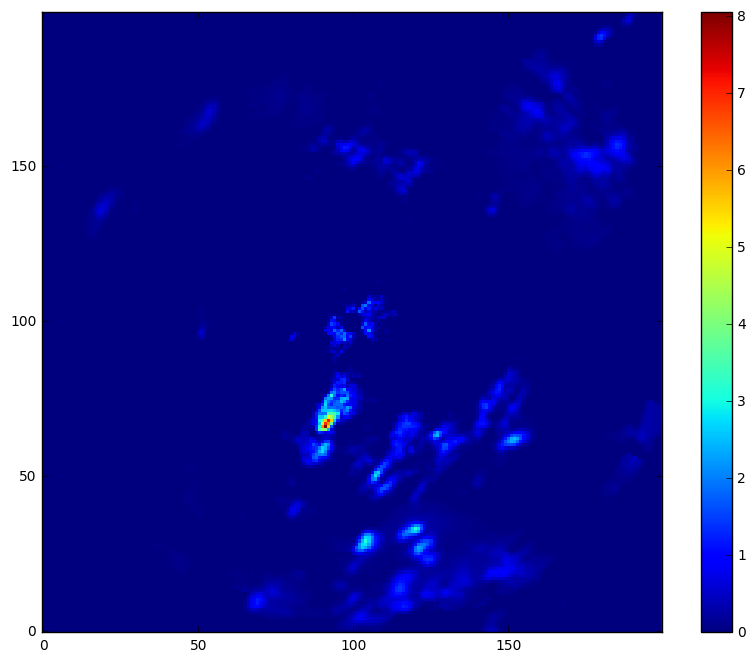

In [140]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
c = ax.imshow(rain, origin='lower', interpolation='None', vmin=0)
plt.colorbar(c)
plt.show()

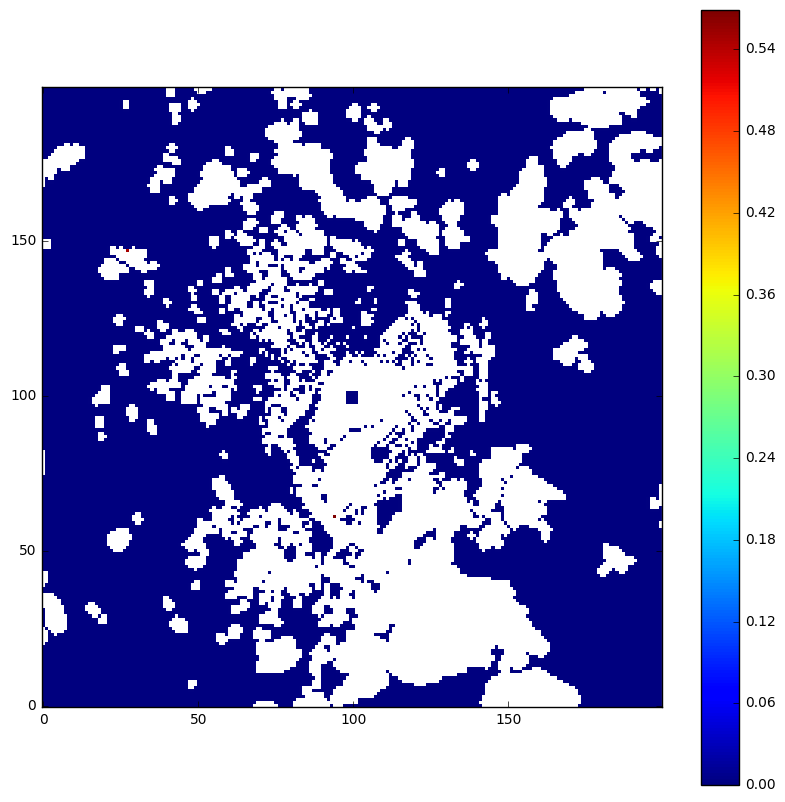

In [180]:
import matplotlib.pyplot as plt
#grid = pyart.map.grid_from_radars(
#    (radar_se, radar_sw), gatefilters=(gatefilter_se, gatefilter_sw),
#    grid_shape=(1, 201, 201),
#    grid_limits=((1000, 1000), (-50000, 40000), (-60000, 40000)),
#    grid_origin = (36.57861, -97.363611),
#    fields=['corrected_reflectivity_horizontal'])

# create the plot
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
c = ax.imshow(m0.fields['r_kdp']['data'][0].data, origin='lower', interpolation='None')
plt.colorbar(c)
plt.show()

In [84]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pyart.graph

In [281]:
type(display)


pyart.graph.gridmapdisplay.GridMapDisplay

In [86]:
import pyart.graph
display = pyart.graph.GridMapDisplay(m0)

In [95]:
m0.radar_latitude

{'data': array([ 37.59104919]),
 'long_name': 'Latitude of radars used to make the grid.',
 'units': 'degrees_north'}

In [131]:
lat = m0.point_latitude['data'][0]
lon = m0.point_longitude['data'][0]
data = m0.fields['rain']['data'][0]

In [169]:
import cartopy.crs as ccrs
from cartopy.io import img_tiles
import cartopy.io.shapereader as shpreader

In [170]:
from cartopy.io.img_tiles import GoogleTiles
class ShadedReliefESRI(GoogleTiles):
    # shaded relief
    def _image_url(self, tile):
        x, y, z = tile
        url = ('https://server.arcgisonline.com/ArcGIS/rest/services/' \
               'World_Shaded_Relief/MapServer/tile/{z}/{y}/{x}.jpg').format(
               z=z, y=y, x=x)
        return url

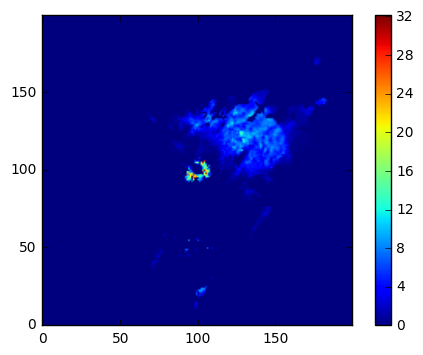

In [172]:
c = plt.imshow(m0.fields['rain']['data'][0].data, origin='lower')
plt.colorbar(c)

In [135]:
list(shp.geometries())

In [152]:
from cartopy.feature import ShapelyFeature
from cartopy.io.shapereader import Reader


In [161]:
ccrs.UTM

-111.71330734711735

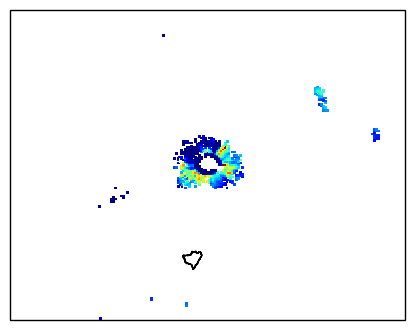

In [165]:
shpfile='/data/UTAH/BasinBound/ShortCreek.shp'

shape_feature = ShapelyFeature(Reader(shpfile).geometries(),
                               ccrs.UTM(12), facecolor='none')

ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(shape_feature)
ax.set_extent([lon.min(), lon.max(), lat.min(), lat.max()])
ax.pcolormesh(lon, lat, data)

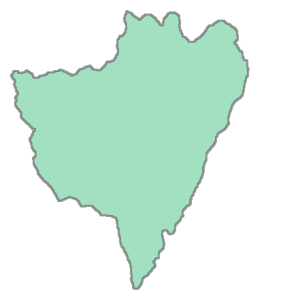

In [140]:
from shapely.ops import cascaded_union
shpfile='/data/UTAH/BasinBound/ShortCreek.shp'
shp = shpreader.Reader(shpfile)
geoms = shp.geometries()
polygon = cascaded_union(list(geoms))
polygon

In [ ]:
from shapely.geometry import Point

def inpolygon(polygon, xp, yp):
    return np.array([Point(x, y).intersects(polygon) for x, y in zip(xp, yp)],
                    dtype=np.bool)

mask1d = inpolygon(polygon, lon.ravel(), lat.ravel())
mask2d = mask1d.reshape(lon.shape)

In [ ]:
import numpy.ma as ma

rain = ma.masked_array(data, ~mask2d)

plt.pcolormesh(lon, lat, rain
ax.set_extent(geom.bounds)

In [ ]:
rain.sum()

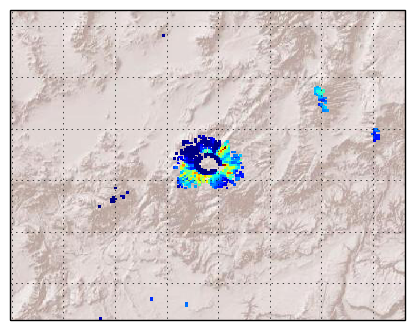

In [91]:
ax = plt.axes(projection = ccrs.PlateCarree())
ax.pcolormesh(lon, lat, data)
ax.gridlines()
ax.add_image(ShadedReliefESRI(), 8)

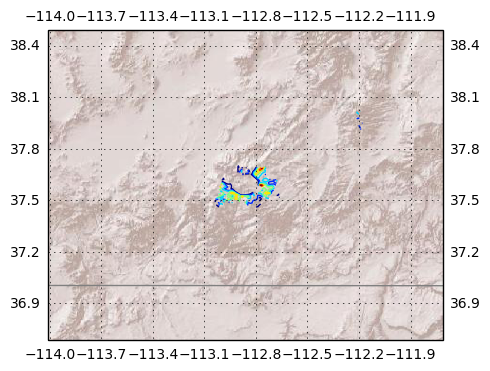

In [92]:
import cartopy.feature as cfeature

states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')

ax = plt.axes(projection=ccrs.PlateCarree())
ax.contour(lon, lat, data)
ax.gridlines(draw_labels=True)
ax.add_image(ShadedReliefESRI(), 8)
ax.add_feature(states_provinces, edgecolor='gray')

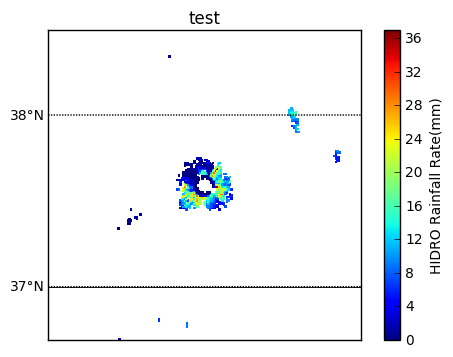

In [96]:
import pyart.graph
display.plot_basemap()
display.plot_grid('rain', level=0, norm=None, cmap=None, mask_outside=False, 
                  title='test', title_flag=True, axislabels=(None, None),
                  colorbar_orient='vertical', edges=True) 
                        